<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/3_Data_balacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Purity
0     771
1    2651
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


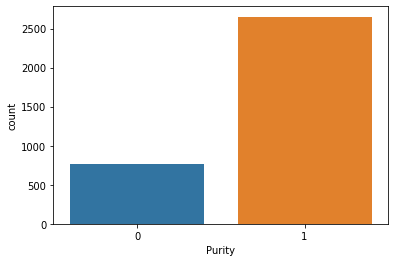

In [76]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/chosen_dataset_lasso.csv')

df.dropna(inplace = True)
df["date"] = pd.to_datetime(df["date"])
df.insert(0,'new_date',pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
df.drop(['date'], axis=1, inplace=True)
print(df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = df)

In [77]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(['Purity'], axis=1)
y = df['Purity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2395, 19), (2395,), (1027, 19), (1027,))

## Smote-Enn

In [78]:
print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_enn = SMOTEENN()
X_train_smote_enn_res, y_train_smote_enn_res = smote_enn.fit_resample(X_train, y_train.ravel())

print("After smote-enn: counts of label '1': {}".format(sum(y_train_smote_enn_res==1)))
print("After smote-enn: counts of label '0': {}".format(sum(y_train_smote_enn_res==0)))
X_train_smote_enn_res.shape, y_train_smote_enn_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 1866
Before: counts of label '0': 529 

After smote-enn: counts of label '1': 1135
After smote-enn: counts of label '0': 1310


((2445, 19), (2445,), (1027, 19), (1027,))

## Smote-TomerLink

In [79]:
print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))
X_train_smote_tl_res.shape, y_train_smote_tl_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 1866
Before: counts of label '0': 529 

After smote-tl: counts of label '1': 1628
After smote-tl: counts of label '0': 1628


((3256, 19), (3256,), (1027, 19), (1027,))

## KNN classification for comparaison

In [80]:
smote_enn_df = {'x_train': X_train_smote_enn_res, 'y_train': y_train_smote_enn_res}
smote_tl_df = {'x_train': X_train_smote_tl_res, 'y_train': y_train_smote_tl_res}

all_dfs = [smote_enn_df, smote_tl_df]

0 78.67575462512171
_______________________________________________
1 82.1811100292113
_______________________________________________
{'dataset': 1, 'accuracy': 82.1811100292113, 'best_params': ['manhattan', 5, 'distance']}
              precision    recall  f1-score   support

           0       0.60      0.74      0.66       242
           1       0.91      0.85      0.88       785

    accuracy                           0.82      1027
   macro avg       0.76      0.79      0.77      1027
weighted avg       0.84      0.82      0.83      1027



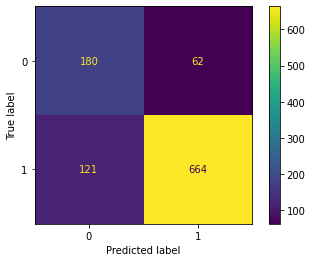

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

#initialisation
best_params = 0
model = 0
accuracy = 0
i = 0
max = {'dataset': i, 'accuracy': accuracy, 'best_params': best_params}

for df in all_dfs:

  grid_params = {
      'n_neighbors' : [5, 7, 11, 19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(all_dfs[i]['x_train'], all_dfs[i]['y_train'])
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(all_dfs[i]['x_train'], all_dfs[i]['y_train'])
  y_test_hat = model.predict(X_test) 
  test_accuracy = accuracy_score(y_test,y_test_hat)*100
  if accuracy  < test_accuracy:
    accuracy = test_accuracy
    max = { 'dataset': i, 'accuracy': accuracy, 'best_params': best_params }
  print(i,test_accuracy)
  i = i + 1
  print('_______________________________________________')

print(max)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

✅ Conclusion: Best approach is smote-tomerLink for our case

In [82]:
X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'purity',y_train)

X_train_smote_enn_res.insert(0,'dates',pd.to_datetime(X_train_smote_enn_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_enn_res.drop('new_date', axis=1, inplace=True)
X_train_smote_enn_res.insert(len(X_train_smote_enn_res.columns),'purity',y_train_smote_enn_res)

final = X_train.append(X_train_smote_enn_res, ignore_index=True)
final = final.sort_values(by="dates")

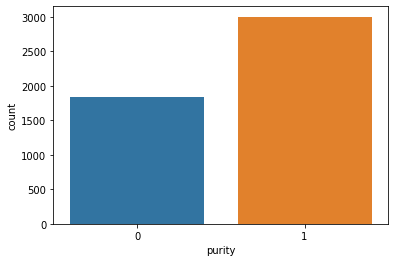

In [88]:
sns.countplot(x ='purity', data = final)